# Feature Selection

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install xarray
    !pip3 install rasterio
    !pip3 install fiona
    !pip install matplotlib-scalebar
    !pip install XlsxWriter
    !pip3 install rioxarray
    !pip install plotnine pdpbox

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_validate
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import os
import fiona
import geopandas as gpd
import importlib

from numpy import absolute


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir =  '/content/drive/MyDrive/Thesis/Clean Thesis code/'

import sys
sys.path.append(os.path.join(base_dir, 'scripts'))

import modeling
from modeling import Metrics

import Config
importlib.reload(Config)

from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict)

importlib.reload(modeling)

Database_gpkg = os.path.join(base_dir, 'Database.gpkg')
Model_data = os.path.join(base_dir, 'Model_data.gpkg')
print(f"Model_data: {fiona.listlayers(Model_data)}")
print(f"Database_gpkg: {fiona.listlayers(Database_gpkg)}")

Mounted at /content/drive
Model_data: ['plots_data', 'train_data', 'test_data', 'Final_data']
Database_gpkg: ['BHR1', 'BHW2', 'Wolfskehlen', 'Leinhardt', 'processed_data', 'processed_data_folds', 'Training_data', 'Validation_data', 'AOI_Hessen', 'AOI_wolf', 'Tectonics', 'Landkreis']


In [ ]:
def remove_negative(df):
    """
    Remove negative values from the DataFrame.
    """
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].clip(lower=0)

    return df

In [ ]:
#Load data
train_data = gpd.read_file(Model_data, layer='train_data', driver='GPKG')
test_data = gpd.read_file(Model_data, layer='test_data', driver='GPKG')
Final_data= gpd.read_file(Model_data, layer='Final_data', driver='GPKG')

datasets = [train_data, test_data, Final_data]
dfp = []

for dataset in datasets:
  df=dataset.copy()
  df = dataset.drop(columns_to_drop, axis=1).rename(columns= {'Rn_Poten':'GRP'})
  df = remove_negative(df)
  dfp.append(df)

train_sample, test_sample, Final_sample = dfp[0], dfp[1], dfp[2]

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


In [ ]:
#train_sample.to_file(Model_data, layer='train_sample', driver='GPKG')
#test_sample.to_file(Model_data, layer='test_sample', driver='GPKG')
#Final_sample.to_file(Model_data, layer='Final_sample', driver='GPKG')

print(Final_data.shape)
print(Final_sample.shape)

(1509, 67)
(1509, 53)


In [ ]:
from sklearn.preprocessing import StandardScaler

def scaled_data(unscaled_df):
    """
    Scale the data excluding specified columns.
    """
    data_to_scale = unscaled_df.copy()
    feature_to_exclude = 'grids_36k'
    features_to_scale = [col for col in data_to_scale.columns if col != feature_to_exclude]
    scaler = StandardScaler()
    data_to_scale[features_to_scale] = scaler.fit_transform(data_to_scale[features_to_scale])

    return data_to_scale

def drop_all_seasonal_values(scaled_data):
    """
    Drop columns identified as seasonal variables from the DataFrame.
    """
    scaled_multiannual = scaled_data.drop(seasonal_variables, axis=1)

    return scaled_multiannual

scaled_train = scaled_data(train_sample)
scaled_train_nonseasonal = drop_all_seasonal_values(scaled_data(train_sample))

In [ ]:
X = train_sample.iloc[:,1:]#.drop(columns=['grids_30k', 'grids_40k',], axis=1)
y = train_sample["GRP"]

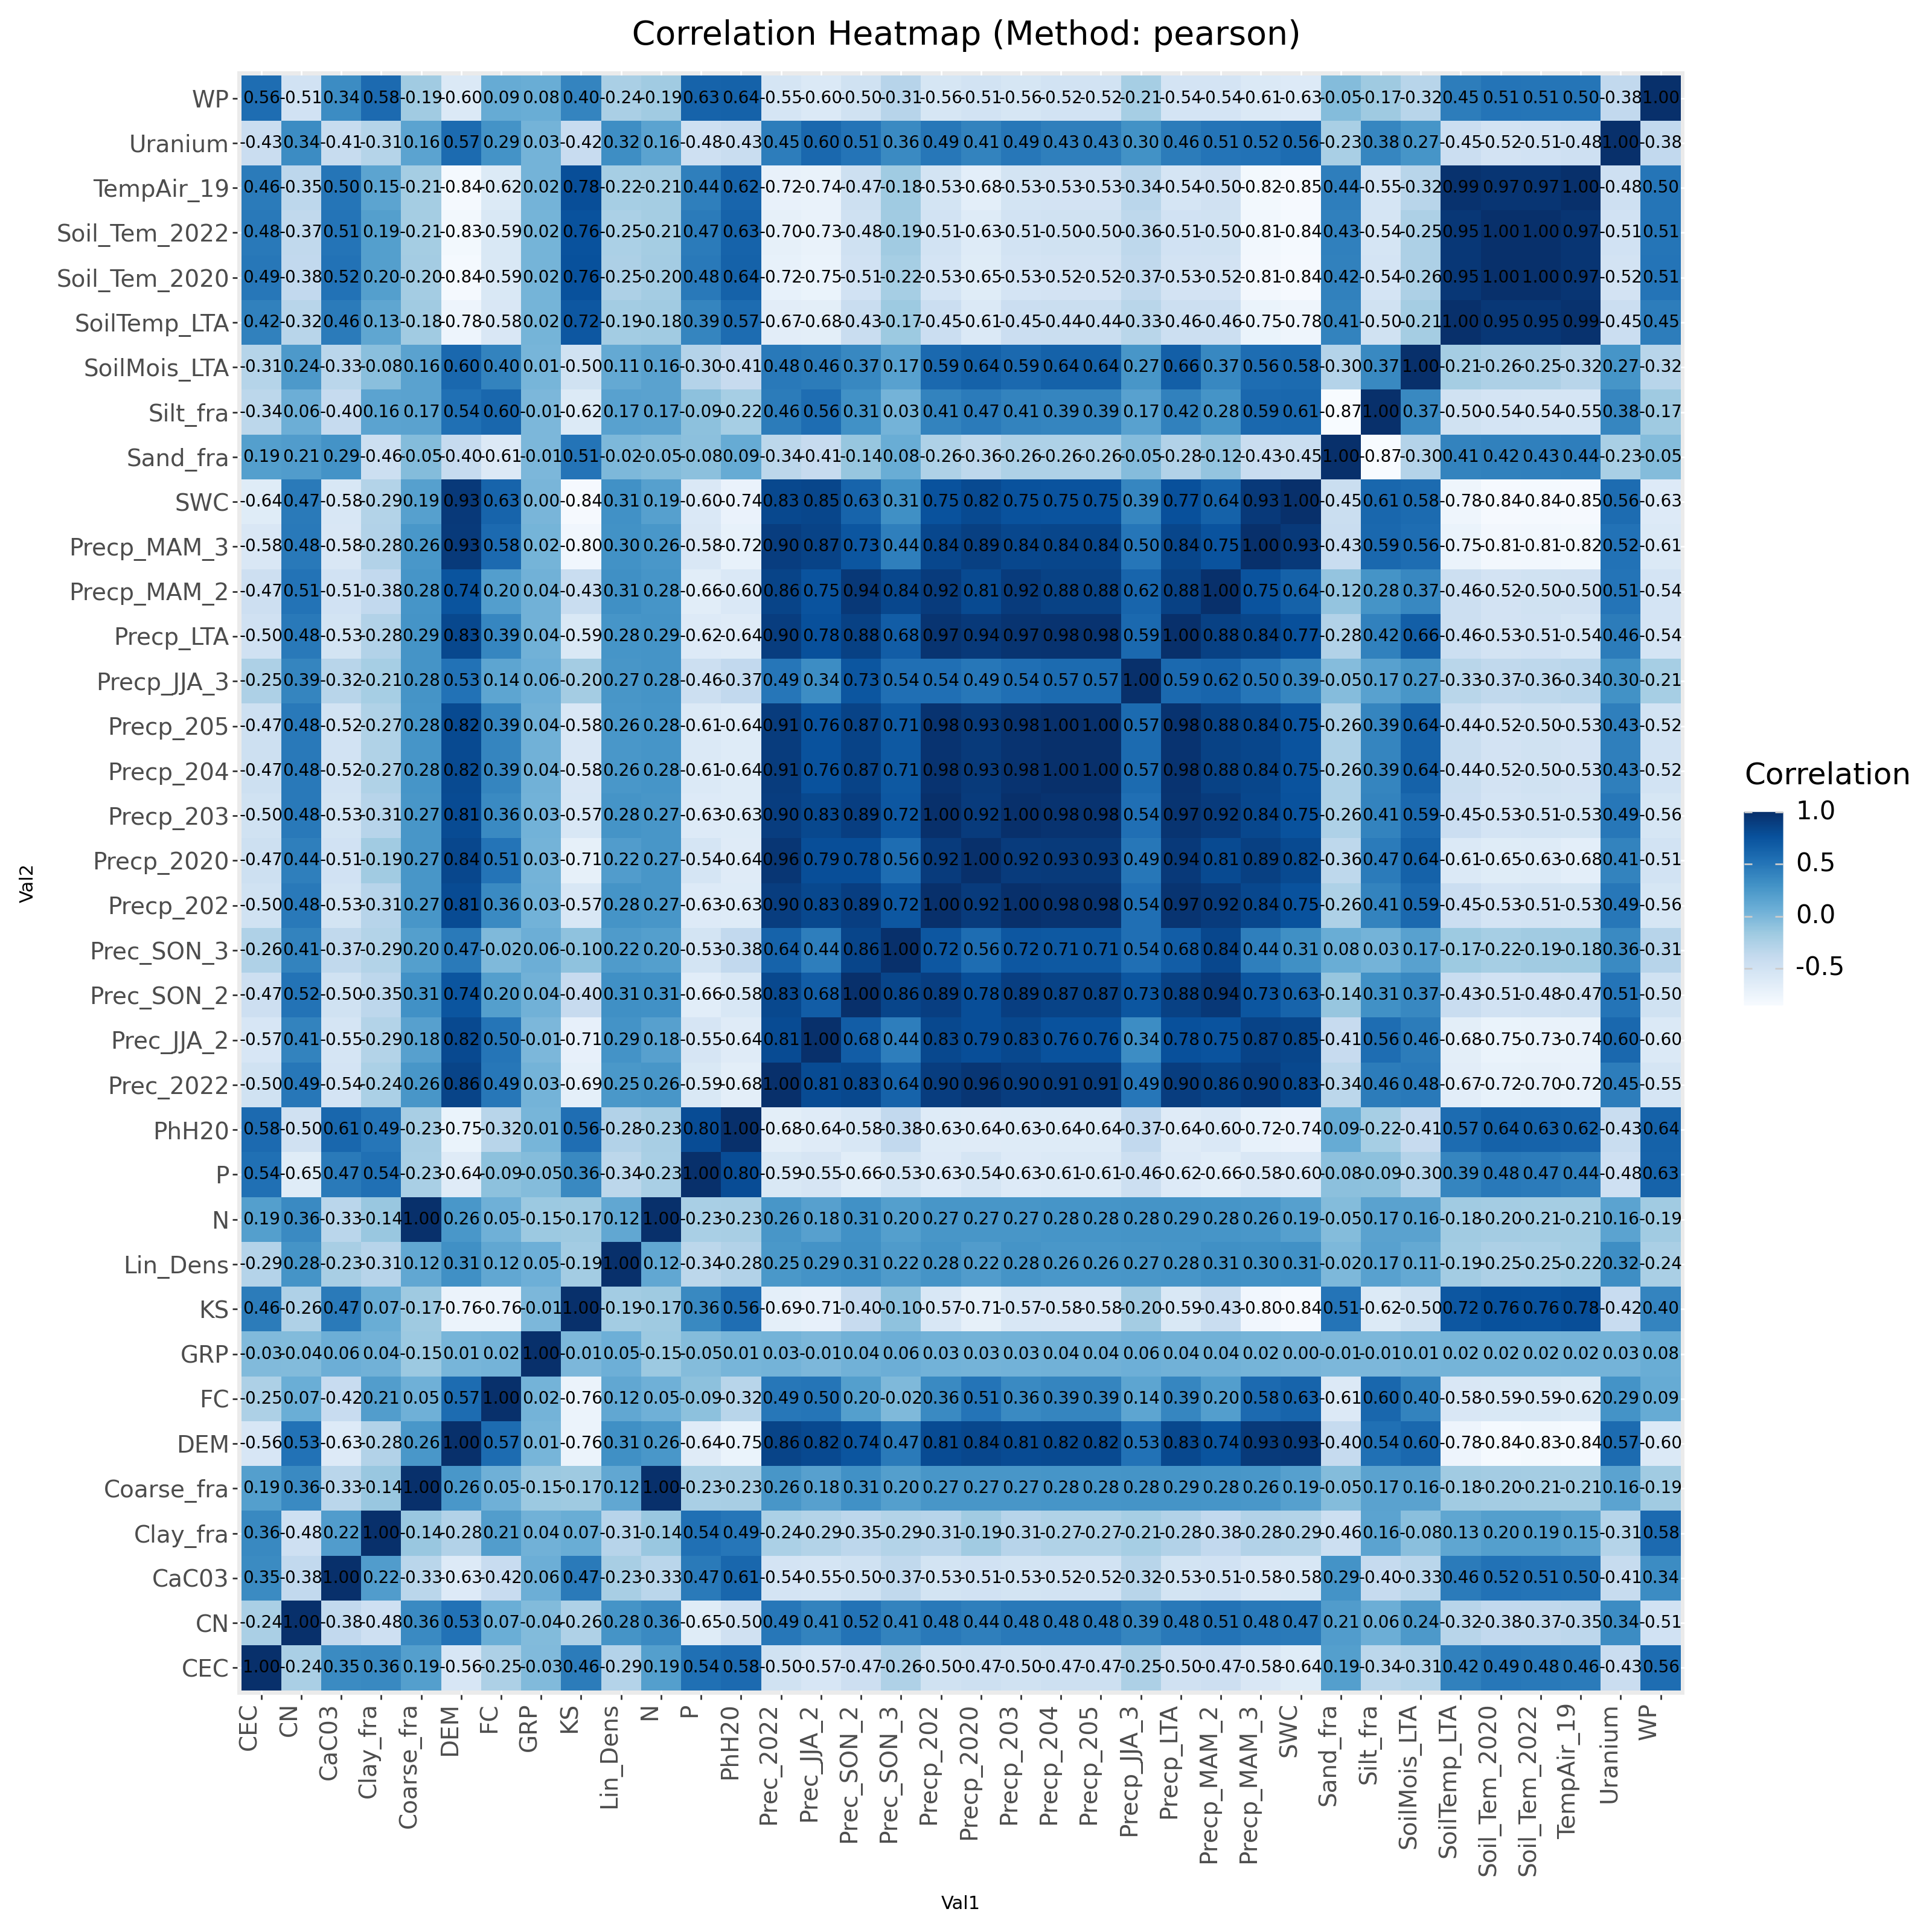

In [ ]:
df_corr = train_sample.drop(df_corr_columns_to_drop, axis=1)
df_corr_renamed = df_corr.rename(columns=rename_preds_dict)

import pandas as pd
from plotnine import ggplot, aes, geom_tile, geom_text, labs, theme, element_text, scale_fill_cmap

def make_and_plot_half_correlation_heatmap(
    data_frame: pd.DataFrame,
    method: str = 'pearson',
    figsize: tuple = (15, 15)
) -> ggplot:
    """
    Computes the correlation matrix for specified columns, renames columns, and returns a half-heatmap plot.
    """

    # Compute correlation matrix
    data_corr = data_frame.corr(method=method)

    # Convert to long format
    data_corr_long = data_corr.stack().reset_index()
    data_corr_long.columns = ["Val1", "Val2", "Correlation"]

    # Keep only the bottom-right triangle (excluding the diagonal)
    #data_corr_long = data_corr_long[data_corr_long["Val1"] < data_corr_long["Val2"]]

    # Create the heatmap plot
    heatmap = (
        ggplot(data_corr_long) +
        geom_tile(aes(x="Val1", y="Val2", fill="Correlation")) +
        geom_text(aes(x="Val1", y="Val2", label="Correlation"), format_string='{:.2f}', size=10) +
        labs(title=f" Correlation Heatmap (Method: {method})") +
        theme(
            figure_size=figsize,
            plot_title=element_text(hjust=0.5, size=20),
            axis_text_x=element_text(angle=90, hjust=1, size=14),
            axis_text_y=element_text(size=14),
            legend_title=element_text(size=18),
            legend_text=element_text(size=15)
        ) +
        scale_fill_cmap(cmap_name="Blues")
    )

    return heatmap
make_and_plot_half_correlation_heatmap(
   df_corr_renamed,
   'pearson',
    figsize = (16, 16)
)

In [ ]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.ensemble import RandomForestClassifier as rfc

In [ ]:
feature_names=tuple(X.columns)
X.shape, y.shape
group_column='grids_36k'
target_column='GRP'

In [ ]:
from numpy import sqrt, mean
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
loo = LeaveOneGroupOut()
warnings.simplefilter(action='ignore', category=FutureWarning)

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [ ]:
def feature_groups(dataframe):
    """
    Create a list of feature groups for the given DataFrame, where some features are grouped together.

    :param dataframe: DataFrame containing the data.
    :return: List of feature groups as lists of column indices.
    """
    filtered_dataframe = dataframe.drop(columns=['GRP', 'grids_36k'], axis=1)
    ungrouped_features = filtered_dataframe.drop(columns=feature_groups_list, axis=1)
    ungrouped_features_list = [
        [filtered_dataframe.columns.get_loc(col)] for col in ungrouped_features]

    grouped_features_tuple = [
        filtered_dataframe.columns.get_loc(col) for col in feature_groups_list
    ]
    grouped_features_list = [grouped_features_tuple]

    # Combine ungrouped and grouped features
    feature_group_all = ungrouped_features_list + grouped_features_list

    return feature_group_all

feature_group = feature_groups(train_sample)
feature_group_seasonal = feature_groups(scaled_train_nonseasonal)

## Sequential Feature selection

In [ ]:
class RenameUnit:
    def __init__(self, geo_data, default_col):
        """
        Initialize the GeologyDataProcessor with the base GeoDataFrame.
        """
        self.geo_data = geo_data
        self.default_col = default_col

    def replace_vals(self, new_column, ref_column, old_values, new_values):
        """
        Replace values in the GeoDataFrame based on specified mappings.

        :param new_column: Column to create with new values.
        :param ref_column: Column to replace values based on.
        :param old_values: List of old values to be replaced.
        :param new_values: List of new values for replacement.
        :return: Updated GeoDataFrame.
        """
        value_mapping = dict(zip(old_values, new_values))
        self.geo_data[new_column] = self.geo_data[ref_column].replace(value_mapping)
        return self.geo_data

    def process_geology_columns(self):
        """
        Applies sequential replacement mappings to create updated geology columns.

        :return: Updated GeoDataFrame with new geology columns.
        """
        # Mapping dictionaries
        old_values1 = ['Triassic, Middle (Muschelkalk)','Triassic, Lower (Buntsandstein)',
                       'Triassic, Middle to Upper (Keuper)', 'Holocene', 'Tertiary (fluviatile)',
                       'Tertiary (volcanites)', 'Pleistocene', 'Permian, Upper (Zechstein)',
                       'Carboniferous', 'Jurassic, Lower', 'Paleozoic igneous rocks',
                       'Devonian, Middle', 'Devonian, Upper', 'Silurian', 'Devonian, Lower',
                       'Ordovician', 'Permian, Lower to Middle (Rotliegend)', 'Paleozoic (metamorph)',
                       'Devonian to Carboniferous (plutonites)']

        new_values1 = ['Triassic, Middle (Muschelkalk)','Triassic, Lower (Buntsandstein)',
                       'Triassic, Middle to Upper (Keuper)', 'Holocene', 'Tertiary (fluviatile)',
                       'Tertiary (volcanites)', 'Pleistocene', 'Permian, Upper (Zechstein)',
                       'Carboniferous', 'Triassic, Lower (Buntsandstein)', 'Paleozoic igneous rocks',
                       'Devonian, Middle', 'Devonian, Upper', 'Triassic, Lower (Buntsandstein)',
                       'Devonian, Lower', 'Triassic, Lower (Buntsandstein)', 'Permian, Lower to Middle (Rotliegend)',
                       'Paleozoic (metamorph)', 'Devonian to Carboniferous (plutonites)']

        old_geo = ['Triassic, Middle (Muschelkalk)', 'Triassic, Lower (Buntsandstein)',
                   'Triassic, Middle to Upper (Keuper)', 'Holocene', 'Tertiary (fluviatile)',
                   'Tertiary (volcanites)', 'Pleistocene', 'Permian, Upper (Zechstein)',
                   'Carboniferous', 'Jurassic, Lower', 'Paleozoic igneous rocks', 'Devonian, Middle',
                   'Devonian, Upper', 'Silurian', 'Devonian, Lower', 'Ordovician',
                   'Permian, Lower to Middle (Rotliegend)', 'Paleozoic (metamorph)',
                   'Devonian to Carboniferous (plutonites)']

        new_geo = ['Triassic Muschelkalk', 'Triassic Bunter sandstone', 'Triassic Keuper',
                   'Holocene sedimentary rocks', 'Tertiary fluviatile', 'Tertiary volcanics',
                   'Pleistocene sediments', 'Late Permian Zechstein', 'Carboniferous felsic volcanics',
                   'Triassic Bunter sandstone', 'Paleozoic mafic volcanics', 'Mid-upper Devonian sediments',
                   'Devonian volcanics', 'Triassic Bunter sandstone', 'Devonian fluviatile',
                   'Triassic Bunter sandstone', 'Permian Rotliegend sediments',
                   'Paleozoic Intermediate-felsic plutonites', 'Devonian to Carboniferous plutonites']

        new_geoid = ['GEOID 5', 'GEOID 7', 'GEOID 6', 'GEOID 1', 'GEOID 3', 'GEOID 11', 'GEOID 2',
                     'GEOID 4', 'GEOID 12', 'GEOID 7', 'GEOID 14', 'GEOID 8', 'GEOID 13', 'GEOID 7',
                     'GEOID 9', 'GEOID 7', 'GEOID 10', 'GEOID 15', 'GEOID 16']

        # Apply replacements
        self.replace_vals('Geo_class', self.default_col, old_values1, new_values1)
        self.replace_vals('class_geo', 'Geo_class', old_geo, new_geo)
        self.replace_vals('GEOID', 'class_geo', new_geo, new_geoid)

        return self.geo_data


def plot_boxplot_by_category(df, category_col, value_col, log_transform=False):
    """
    Plots a boxplot for each category in a DataFrame, with an option for log-scaling the values.

    Parameters:
    df (pd.DataFrame): main dataframe
    category_col (str): col of interest
    value_col (str): numerical aggregator
    log_transform (bool): log transformation

    Returns:
    None: Displays the boxplot.
    """
    transformed_values = df[value_col].copy()

    if log_transform:
        transformed_values = transformed_values.replace(0, np.nan)
        transformed_values = np.log1p(transformed_values)
    plt.figure(figsize=(12, 8))
    plt.boxplot(
        [transformed_values[df[category_col] == cat] for cat in df[category_col].unique()],
                labels=df[category_col].unique(), patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                medianprops=dict(color='red'),
                vert=False
        )

    title = f'Boxplot of {"log-transformed " if log_transform else ""}{value_col} by {category_col}'
    plt.title(title)
    plt.xlabel(f'{"Log-transformed " if log_transform else ""}{value_col}')
    plt.ylabel(category_col)

    plt.show()

plot_boxplot_by_category(geology_radon, 'class_geo', 'GRP', log_transform=False)
plot_boxplot_by_category(geology_radon, 'class_geo', 'GRP', log_transform=True)

import pandas as pd

def calculate_aggregated_stats(df, group_col, value_col, agg_type='median', percentile=None):
    """
    Calculate aggregated statistics by grouping the DataFrame by a specified column.

    Parameters:
    df (pd.DataFrame): Main dataframe
    group_col (str): col of interest
    value_col (str): aggregating column
    agg_type (str): The type of aggregation ('median' or 'percentile'). Default is 'median'.
    percentile (float): The percentile to agg_type is . Should be between 0 and 100.

    Returns:
    pd.DataFrame: A DataFrame with aggregated statistics and ranks, rounded to 2 decimal places.
    """

    if agg_type == 'percentile' and percentile is not None:
        agg_func = lambda x: x.quantile(percentile / 100)
        agg_type_col = f'{percentile}th Percentile'
    else:
        agg_func = agg_type
        agg_type_col = agg_type.capitalize()

    agg_df = df.groupby(group_col)[value_col].agg(['min', 'max', 'mean', agg_func, 'count', 'std'])
    agg_df.columns = ['min', 'max', 'mean', agg_type_col, 'count', 'std']
    agg_df = agg_df.round(2)
    agg_df['Rank'] = agg_df[agg_type_col].rank(ascending=False)

    agg_df = agg_df.sort_values('Rank')

    return agg_df



In [ ]:
def SFS_Algorithm_groups(data, target_column, group_column, base_estimator):
    """
    Perform Sequential Feature Selection (SFS) using grouped features.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :return: Tuple containing the plot figure, selected feature names, and metrics DataFrame.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Get feature groups
    feat_groups = feature_groups(data)

    # Initialize and fit the SFS model
    sfs = SFS(
        base_estimator,
        k_features=(10),
        forward=True,
        floating=False,
        feature_groups=feat_groups,
        scoring='r2',
        verbose=10,
        cv=loo
    )
    sfs = sfs.fit(X, y, groups=groups)

    # Plot the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {base_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    return fig, selected_features, sfs_metrics

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt
import pandas as pd

def SFS_Algorithm(data, target_column, group_column, base_estimator, max_features=35):
    """
    Perform Sequential Feature Selection (SFS) using grouped features and calculate feature importances.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :param max_features: Maximum number of features to select.
    :return: Tuple containing the plot figure, selected feature names, metrics DataFrame, and feature importances.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Get feature groups
    feat_groups = feature_groups(data)  # Assume feature_groups function is defined to group features

    # Define Leave-One-Group-Out (LOO) cross-validator
    loo = LeaveOneGroupOut()

    # Initialize and fit the SFS model
    sfs = SFS(
        base_estimator,
        k_features=max_features,
        forward=True,
        floating=False,
        scoring='r2',
        cv=loo,
        verbose=2,
    )

    sfs = sfs.fit(X, y, groups=groups)

    # Plot the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {base_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Train the base estimator on the selected features to get feature importance
    X_selected = X.loc[:, selected_features]
    base_estimator.fit(X_selected, y)

    if hasattr(base_estimator, 'feature_importances_'):
        # Use feature_importances_ for models with this attribute
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': base_estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    else:
        # Use permutation importance for models without feature_importances_
        perm_importance = permutation_importance(base_estimator, X_selected, y, n_repeats=10, random_state=0)
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return fig, selected_features, sfs_metrics, feature_importances


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

def SFS_Algorithm_with_GridSearch(data, target_column, group_column, base_estimator, param_grid, max_features=35):
    """
    Perform Sequential Feature Selection (SFS) with GridSearchCV using grouped features and calculate feature importances.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :param param_grid: Dictionary of hyperparameters for grid search.
    :param max_features: Maximum number of features to select.
    :return: Tuple containing the plot figure, selected feature names, metrics DataFrame, and feature importances.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Get feature groups
    feat_groups = feature_groups(data)  # Assume feature_groups function is defined to group features

    # Define Leave-One-Group-Out (LOO) cross-validator
    loo = LeaveOneGroupOut()

    # GridSearchCV for the base estimator
    grid_search = GridSearchCV(base_estimator, param_grid, scoring='r2', cv=loo, verbose=1, n_jobs=-1)
    grid_search.fit(X, y, groups=groups)
    best_estimator = grid_search.best_estimator_

    # Initialize and fit the SFS model with the best estimator
    sfs = SFS(
        best_estimator,
        k_features=max_features,
        forward=True,
        floating=False,
        scoring='r2',
        cv=loo,
        verbose=10,
    )

    sfs = sfs.fit(X, y, groups=groups)

    # Plot the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {best_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Train the best estimator on the selected features to get feature importance
    X_selected = X.loc[:, selected_features]
    best_estimator.fit(X_selected, y)

    if hasattr(best_estimator, 'feature_importances_'):
        # Use feature_importances_ for models with this attribute
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': best_estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    else:
        # Use permutation importance for models without feature_importances_
        perm_importance = permutation_importance(best_estimator, X_selected, y, n_repeats=10, random_state=0)
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return fig, selected_features, sfs_metrics, feature_importances, best_estimator


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20],
    'oob_score':[True,False],
}
fig, selected_features, sfs_metrics, feature_importances, best_estimator = SFS_Algorithm_with_GridSearch(
    train_sample,
    target_column=target_column,
    group_column=group_column,
    base_estimator=RandomForestRegressor(),
    param_grid=param_grid
)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
df_corr = train_sample.drop(df_corr_columns_to_drop, axis=1)


## RF Regressor

In [ ]:
RF_sfs = RandomForestRegressor(n_estimators=500,max_depth=None, oob_score=True, random_state=24)


In [ ]:
rf_fig, rf_selected_features, rf_sfs_metrics, rf_feature_importances =  SFS_Algorithm(train_sample,target_column, group_column, RF_sfs)

In [ ]:
rf_feature_importances

#### SFS normal

In [ ]:
#fig_RF,features_RF, sfs_met_RF =  SFS_Algorithm(train_sample, target_column,
#                                                group_column, RF_sfs)

In [ ]:
#fig_RF

In [ ]:
#sfs_met_RF

In [ ]:
#features_RF

### GBR

In [ ]:
#fig_RFg,features_RFg, sfs_met_RFg =  SFS_Algorithm_groups(train_sample, target_column,
#                                                group_column, RF_sfs)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # Import the GradientBoostingRegressor class

gbr_sfs = GradientBoostingRegressor(n_estimators=100, max_depth=None, learning_rate=0.1) # Now you can use it

In [ ]:
gbr_fig, gbr_selected_features, gbr_sfs_metrics, gbr_feature_importances =  SFS_Algorithm(train_sample,target_column, group_column, gbr_sfs)

In [ ]:
#features_RFg

In [ ]:
#sfs_met_RFg

### Without seasonal data

In [ ]:
#fig_RFns,features_RFns, sfs_met_RFns =  SFS_Algorithm(scaled_train_nonseasonal, target_column,
#                                                group_column, RF_sfs)

In [ ]:
#fig_RFns

In [ ]:
#features_RFns

In [ ]:
#sfs_met_RFns

### feature groups

In [ ]:
#fig_RFnsg,features_RFnsg, sfs_met_RFnsg =  SFS_Algorithm_groups(scaled_train_nonseasonal, target_column,
#                                                group_column, RF_sfs)

In [ ]:
#fig_RFnsg

In [ ]:
#features_RFnsg

In [ ]:
#sfs_met_RFnsg

## Gridserach

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

In [ ]:
def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def quantile_loss(true, pred, gamma):
    val1 = gamma * np.abs(true - pred)
    val2 = (1-gamma) * np.abs(true - pred)
    q_loss = np.where(true >= pred, val1, val2)
    return q_loss

def r2_adj(response,true,pred):
    x= response
    r2=r2_score(true,pred)
    n = x.shape[0]
    p = x.shape[1]
    return 1-(1-r2)*(n-1)/(n-p-1)

In [ ]:
import time
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import f_regression

def timer(start_time=None):
    """
    Timer function to track the duration of code execution.

    :param start_time: The start time of the timer.
    :return: If start_time is None, returns the current time. Otherwise, prints the elapsed time and returns it.
    """
    if start_time is None:
        return time.time()
    else:
        elapsed_time = time.time() - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
        return elapsed_time # Added return statement to return the elapsed time

def GridSearchCV_params(df, target_column, group_column, estimator):
    """
    Perform GridSearchCV with cross-validation using Leave-One-Group-Out (LOO) splitting.
    Evaluates the performance metrics and feature importance for the given estimator.

    :param df: DataFrame containing features and target variable.
    :param target_column: Column name of the target variable in the DataFrame.
    :param group_column: Column name of the group variable for LOO cross-validation.
    :param estimator: Estimator object (must support GridSearchCV) to use for fitting and predicting.
    :return: DataFrames containing feature importance, metrics for each fold,
             average metrics scores, and the best estimator parameters.
    """
    X = df.drop(columns=[target_column, group_column])
    y = df[target_column]
    groups = df[group_column].values
    loo = LeaveOneGroupOut()

    metrics = {'RMSE': [], 'R2 Score': [], 'MSE': [], 'MAE': [], 'R2 Adjusted': []}
    feature_importance = []

    total_start_time = timer()  # Start the total timer

    for i, (train_index, test_index) in enumerate(loo.split(X, y, groups=groups)):
        print(f"------ Iteration: {i + 1} --------")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        iteration_start_time = timer()  # Start the timer for the iteration
        estimator.fit(X_train, y_train)

        print("Best Parameters: ", estimator.best_params_)
        print("Best Score: ", estimator.best_score_)
        timer(iteration_start_time)  # Stop the timer for the iteration

        # Extract feature importance using f_regression
        importance = f_regression(X_train, y_train)[0]
        feature_importance.append(importance)

        # Predictions and metric calculations
        y_pred = estimator.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        r2_adju = r2_adj(X_train, y_train, y_pred)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['R2 Adjusted'].append(r2_adju)

    total_elapsed_time = timer(total_start_time)  # Stop the total timer

    best_estimator = estimator.best_params_

    # Metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    avg_metrics_score = metrics_df.mean().to_frame('Score')

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"Total elapsed time for GridSearchCV: {total_elapsed_time:.2f} seconds")

    return importance_df, metrics_df, avg_metrics_score, best_estimator


## RF gridsearch

In [ ]:
param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Initialize RandomForestRegressor and GridSearchCV
rf_grid = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    scoring='r2',  # Using R^2 as the scoring metric
    cv=loo,
    verbose=0,
    n_jobs=-1
)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

def GridSearchCV_params_rf(df, target_column, group_column):
    """
    Perform GridSearchCV with cross-validation using Leave-One-Group-Out (LOO) splitting.
    Specifically designed for RandomForestRegressor hyperparameter tuning.

    :param df: DataFrame containing features and target variable.
    :param target_column: Column name of the target variable in the DataFrame.
    :param group_column: Column name of the group variable for LOO cross-validation.
    :return: DataFrames containing feature importance, metrics for each fold,
             average metrics scores, and the best estimator parameters.
    """
    X = df.drop(columns=[target_column, group_column])
    y = df[target_column]
    groups = df[group_column].values
    loo = LeaveOneGroupOut()

    # Define the parameter grid for RandomForestRegressor
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Initialize RandomForestRegressor and GridSearchCV
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='r2',  # Using R^2 as the scoring metric
        cv=loo,
        verbose=2,
        n_jobs=-1
    )

    # Perform Grid Search with Cross-Validation
    grid_search.fit(X, y, groups=groups)

    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    best_estimator = grid_search.best_estimator_

    # Compute metrics and feature importances using the best estimator
    metrics = {'RMSE': [], 'R2 Score': [], 'MSE': [], 'MAE': [], 'R2 Adjusted': []}
    feature_importance = []

    total_start_time = timer()  # Start the total timer

    for i, (train_index, test_index) in enumerate(loo.split(X, y, groups=groups)):
        print(f"------ Iteration: {i + 1} --------")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        iteration_start_time = timer()  # Start the timer for the iteration
        best_estimator.fit(X_train, y_train)

        # Extract feature importance
        importance = best_estimator.feature_importances_
        feature_importance.append(importance)

        # Predictions and metric calculations
        y_pred = best_estimator.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        r2_adju = r2_adj(X_train, y_train, y_pred)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['R2 Adjusted'].append(r2_adju)

    total_elapsed_time = timer(total_start_time)  # Stop the total timer

    # Metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    avg_metrics_score = metrics_df.mean().to_frame('Score')

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"Total elapsed time for GridSearchCV: {total_elapsed_time:.2f} seconds")

    return importance_df, metrics_df, avg_metrics_score, best_estimator


In [ ]:
importance_dfrf, metrics_dfrf, avg_metrics_scorerf, best_estimatorrf = GridSearchCV_params_rf(scaled_train_nonseasonal, target_column, group_column)


In [ ]:
best_estimatorrf

### SVR Gridsearch

In [ ]:
svr_ =SVR(kernel='rbf')

param_svr={'C': [0.1, 1, 100, 300, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005,
                        0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
svr_grid = GridSearchCV(svr_,param_svr, scoring='neg_mean_squared_error',
                        verbose=0, n_jobs=-1)

In [ ]:
importance_dfsvr, metrics_dfsvr, avg_metrics_scoresvr, best_estimatorsvr = GridSearchCV_params(scaled_train_nonseasonal, target_column, group_column, svr_grid)

In [ ]:
best_estimatorsvr

In [ ]:
avg_metrics_scoresvr

In [ ]:
#importance_dfsvr

In [ ]:
metrics_dfsvr

## GBM gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut

def GridSearchCV_params_gbr(df, target_column, group_column):
    """
    Perform GridSearchCV with cross-validation using Leave-One-Group-Out (LOO) splitting.
    Specifically designed for GradientBoostingRegressor hyperparameter tuning.

    :param df: DataFrame containing features and target variable.
    :param target_column: Column name of the target variable in the DataFrame.
    :param group_column: Column name of the group variable for LOO cross-validation.
    :return: DataFrames containing feature importance, metrics for each fold,
             average metrics scores, and the best estimator parameters.
    """
    X = df.drop(columns=[target_column, group_column])
    y = df[target_column]
    groups = df[group_column].values
    loo = LeaveOneGroupOut()

    # Define the parameter grid for GradientBoostingRegressor
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 1.0]
    }

    # Initialize GradientBoostingRegressor and GridSearchCV
    gbr = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=gbr,
        param_grid=param_grid,
        scoring='r2',  # Using R^2 as the scoring metric
        cv=loo,
        verbose=2,
        n_jobs=-1
    )

    # Perform Grid Search with Cross-Validation
    grid_search.fit(X, y, groups=groups)

    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    best_estimator = grid_search.best_estimator_

    # Compute metrics and feature importances using the best estimator
    metrics = {'RMSE': [], 'R2 Score': [], 'MSE': [], 'MAE': [], 'R2 Adjusted': []}
    feature_importance = []

    total_start_time = timer()  # Start the total timer

    for i, (train_index, test_index) in enumerate(loo.split(X, y, groups=groups)):
        print(f"------ Iteration: {i + 1} --------")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        iteration_start_time = timer()  # Start the timer for the iteration
        best_estimator.fit(X_train, y_train)

        # Extract feature importance
        importance = best_estimator.feature_importances_
        feature_importance.append(importance)

        # Predictions and metric calculations
        y_pred = best_estimator.predict(X_train)
        rmse = np.sqrt(mean_squared_error(y_train, y_pred))
        mse = mean_squared_error(y_train, y_pred)
        mae = mean_absolute_error(y_train, y_pred)
        r2 = r2_score(y_train, y_pred)
        r2_adju = r2_adj(X_train, y_train, y_pred)

        metrics['RMSE'].append(rmse)
        metrics['R2 Score'].append(r2)
        metrics['MAE'].append(mae)
        metrics['MSE'].append(mse)
        metrics['R2 Adjusted'].append(r2_adju)

    total_elapsed_time = timer(total_start_time)  # Stop the total timer

    # Metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    avg_metrics_score = metrics_df.mean().to_frame('Score')

    # Calculate mean feature importance across all folds
    mean_importance = np.mean(feature_importance, axis=0)
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print(f"Total elapsed time for GridSearchCV: {total_elapsed_time:.2f} seconds")

    return importance_df, metrics_df, avg_metrics_score, best_estimator


In [ ]:
importance_dfgbr, metrics_dfgbr, avg_metrics_scoregbr, best_estimatorgbr = GridSearchCV_params_gbr(scaled_train_nonseasonal, target_column, group_column)


In [ ]:
best_estimatorgbr

In [ ]:
metrics_dfgbr